In [25]:
"""
PHASE 1: STATISTICAL FOUNDATIONS
Advanced EDA and Hypothesis Testing for 2024 Startup Data

Learning Goals:
- Hypothesis testing (t-tests, Mann-Whitney U, Chi-square)
- Understanding distributions
- Effect size calculations
- Correlation analysis
- Bootstrap confidence intervals
"""

'\nPHASE 1: STATISTICAL FOUNDATIONS\nAdvanced EDA and Hypothesis Testing for 2024 Startup Data\n\nLearning Goals:\n- Hypothesis testing (t-tests, Mann-Whitney U, Chi-square)\n- Understanding distributions\n- Effect size calculations\n- Correlation analysis\n- Bootstrap confidence intervals\n'

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import bootstrap
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("Setup complete!")


Setup complete!


In [27]:
df = pd.read_csv('main.csv')
import ast
import re

def parse_founded_date(date_str):
    try:
        date_dict = ast.literal_eval(date_str)
        return pd.to_datetime(date_dict['value'])
    except:
        return pd.NaT


In [28]:
df['founded_date'] = df['founded_on'].apply(parse_founded_date)

In [29]:
df.head()

,uuid,name,permalink,founded_on,short_description,website,num_employees_enum,categories,funding_total,funding_total_numeric,num_funding_rounds,founded_date
0,eb2fe359-3789-49df-bbe7-af289c547cc4,World Liberty Financial,world-liberty-financial,"{'precision': 'year', 'value': '2024-01-01'}",World Liberty Financial is a decentralized fin...,{'value': 'https://www.worldlibertyfinancial.c...,c_00011_00050,Blockchain;Cryptocurrency;Web3,950000000.0,950000000.0,3.0,2024-01-01
1,3a40a2fe-4904-4836-be28-83e9e1261dd9,Inception,inception-1dd9,"{'precision': 'year', 'value': '2024-01-01'}",Inception develops diffusion large language mo...,{'value': 'https://www.inceptionlabs.ai'},c_00001_00010,Artificial Intelligence (AI);Information Techn...,56000000.0,56000000.0,2.0,2024-01-01
2,660ad03f-c1fb-42bd-8d39-dcca245e82ce,World Labs,world-labs,"{'precision': 'day', 'value': '2024-01-01'}",World Labs develops AI models with spatial int...,{'value': 'https://www.worldlabs.ai'},c_00011_00050,3D Technology;Artificial Intelligence (AI);Gen...,230000000.0,230000000.0,2.0,2024-01-01
3,c5be4c59-79a6-4109-9703-be3dfd238ddf,Pump.fun,pump-fun,"{'precision': 'year', 'value': '2024-01-01'}",Pump.fun is a memecoin launchpad that enables ...,{'value': 'https://pump.fun/board'},c_00051_00100,Blockchain;Cryptocurrency;FinTech;Trading Plat...,600000000.0,600000000.0,2.0,2024-01-01
4,602e06d7-375b-4689-bad0-ff591fdfed67,DualEntry,dualentry,"{'precision': 'year', 'value': '2024-01-01'}",DualEntry develops an AI-based accounting soft...,{'value': 'https://www.dualentry.com'},c_00011_00050,Accounting;Artificial Intelligence (AI);Enterp...,100000000.0,100000000.0,2.0,2024-01-01


In [30]:
def parse_employee_range(code):
    if pd.isna(code) or code == '':
        return None, None
    numbers = re.findall(r'\d+', code)
    if len(numbers) >= 2:
        return int(numbers[0]), int(numbers[-1])
    return None, None

In [31]:
df[['employees_min', 'employees_max']] = pd.DataFrame(
    df['num_employees_enum'].apply(parse_employee_range).tolist()
)
df['employees_midpoint'] = (df['employees_min'] + df['employees_max']) / 2


In [32]:
df['categories_list'] = df['categories'].apply(
    lambda x: [cat.strip() for cat in str(x).split(';')] if pd.notna(x) and x != '' else []
)
df['category_count'] = df['categories_list'].apply(len)

# Create AI flag
df['has_ai_category'] = df['categories'].str.contains('Artificial Intelligence', na=False, case=False)

# AI mention in description
ai_keywords = ['ai', 'artificial intelligence', 'machine learning', 'deep learning', 
               'neural', 'llm', 'generative ai']
df['mentions_ai'] = df['short_description'].str.lower().str.contains('|'.join(ai_keywords), na=False)

# Combined AI flag
df['is_ai_company'] = df['has_ai_category'] | df['mentions_ai']

In [33]:
print(f"Dataset loaded: {len(df):,} companies")
print(f"AI companies: {df['is_ai_company'].sum():,} ({df['is_ai_company'].sum()/len(df)*100:.1f}%)")
print(f"Features available: {df.columns.tolist()}")

Dataset loaded: 26,012 companies
AI companies: 10,673 (41.0%)
Features available: ['uuid', 'name', 'permalink', 'founded_on', 'short_description', 'website', 'num_employees_enum', 'categories', 'funding_total', 'funding_total_numeric', 'num_funding_rounds', 'founded_date', 'employees_min', 'employees_max', 'employees_midpoint', 'categories_list', 'category_count', 'has_ai_category', 'mentions_ai', 'is_ai_company']


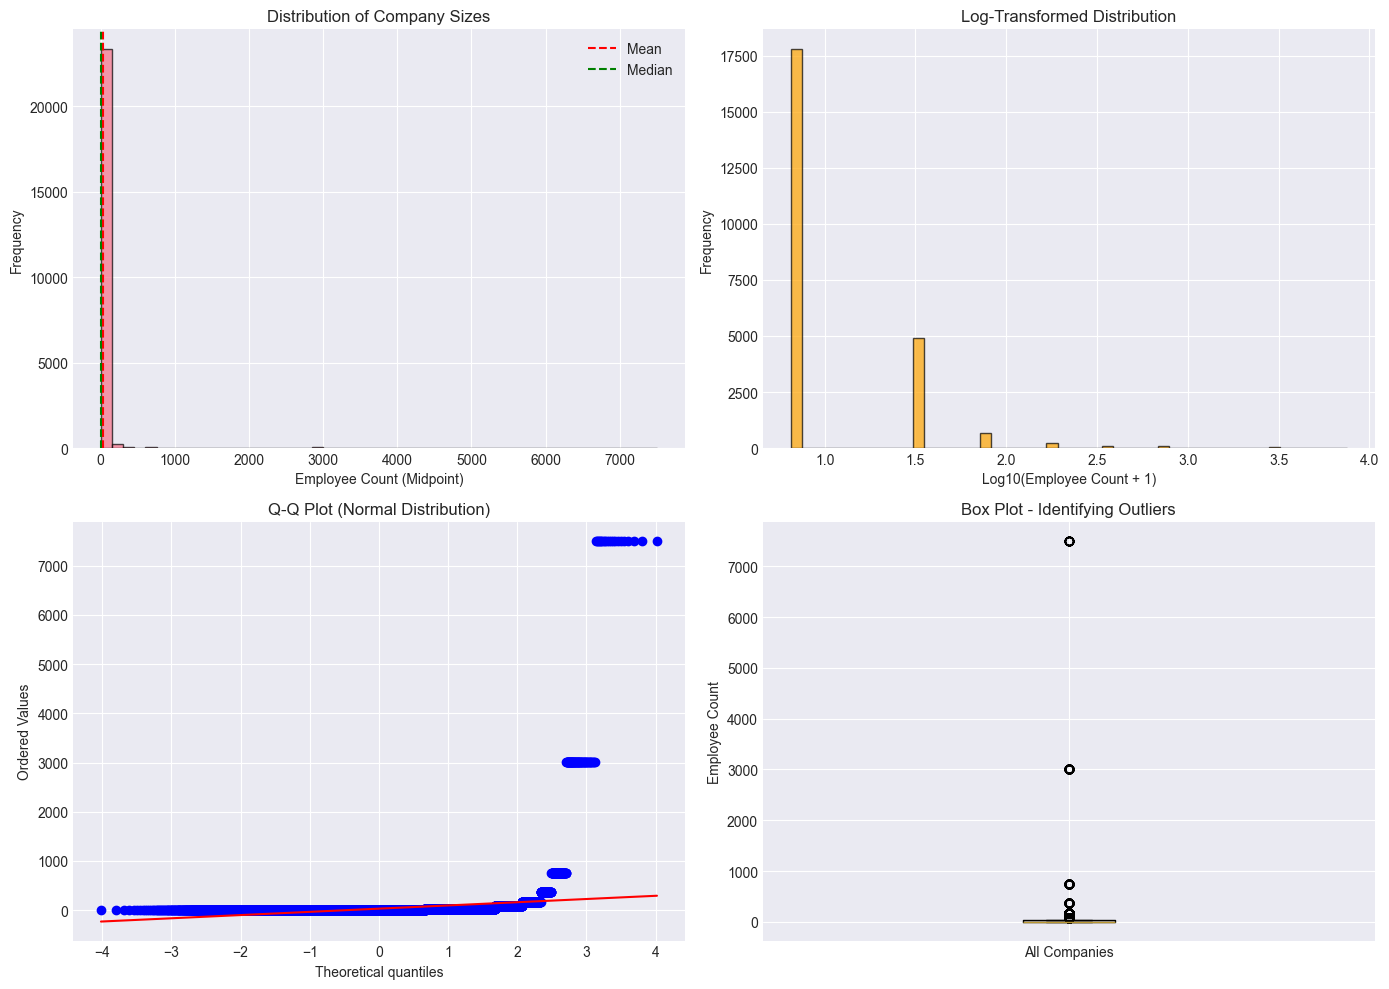

DESCRIPTIVE STATISTICS: EMPLOYEE COUNT
Mean: 31.72
Median: 5.50
Std Dev: 271.63
Skewness: 21.65
Kurtosis: 537.07

Shapiro-Wilk Test for Normality:
  Statistic: 0.0557
  P-value: 1.6898e-94
  Result: NOT normally distributed (p < 0.05)

💡 INTERPRETATION:
- Positive skewness indicates right-skewed distribution (long tail of large companies)
- Q-Q plot shows deviation from normality
- This suggests using non-parametric tests for comparisons


In [34]:
# Cell 3: Part 1 - Distribution Analysis
"""
LEARNING CONCEPT: Understanding Data Distributions

Key Questions:
1. Is the data normally distributed?
2. Are there outliers?
3. What distribution family does it follow?

📚 Quick Learn: https://www.youtube.com/watch?v=rzFX5NWojp0 (Normal Distribution - 10 min)
"""

# 1.1 Employee Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
axes[0, 0].hist(df['employees_midpoint'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Employee Count (Midpoint)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Company Sizes')
axes[0, 0].axvline(df['employees_midpoint'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].axvline(df['employees_midpoint'].median(), color='green', linestyle='--', label='Median')
axes[0, 0].legend()

# Log scale histogram (for skewed data)
axes[0, 1].hist(np.log10(df['employees_midpoint'].dropna() + 1), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Log10(Employee Count + 1)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Log-Transformed Distribution')

# Q-Q Plot (tests for normality)
stats.probplot(df['employees_midpoint'].dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normal Distribution)')

# Box plot
axes[1, 1].boxplot(df['employees_midpoint'].dropna(), vert=True)
axes[1, 1].set_ylabel('Employee Count')
axes[1, 1].set_title('Box Plot - Identifying Outliers')
axes[1, 1].set_xticklabels(['All Companies'])

plt.tight_layout()
plt.show()

# Descriptive statistics
print("=" * 60)
print("DESCRIPTIVE STATISTICS: EMPLOYEE COUNT")
print("=" * 60)
print(f"Mean: {df['employees_midpoint'].mean():.2f}")
print(f"Median: {df['employees_midpoint'].median():.2f}")
print(f"Std Dev: {df['employees_midpoint'].std():.2f}")
print(f"Skewness: {df['employees_midpoint'].skew():.2f}")
print(f"Kurtosis: {df['employees_midpoint'].kurtosis():.2f}")

# Test for normality
shapiro_stat, shapiro_p = stats.shapiro(df['employees_midpoint'].dropna().sample(min(5000, len(df))))
print(f"\nShapiro-Wilk Test for Normality:")
print(f"  Statistic: {shapiro_stat:.4f}")
print(f"  P-value: {shapiro_p:.4e}")
print(f"  Result: {'NOT normally distributed' if shapiro_p < 0.05 else 'Normally distributed'} (p < 0.05)")

print("\n💡 INTERPRETATION:")
print("- Positive skewness indicates right-skewed distribution (long tail of large companies)")
print("- Q-Q plot shows deviation from normality")
print("- This suggests using non-parametric tests for comparisons")

HYPOTHESIS TEST 1: AI vs NON-AI EMPLOYEE COUNTS

Descriptive Statistics:
AI Companies (n=9,932):
  Mean: 25.31 employees
  Median: 5.50 employees
  Std: 236.68

Non-AI Companies (n=13,865):
  Mean: 36.31 employees
  Median: 5.50 employees
  Std: 294.05

Levene's Test for Equal Variances:
  Statistic: 9.5062
  P-value: 0.0021
  Result: Unequal variances (p < 0.05)

Independent t-test:
  t-statistic: -3.1941
  p-value: 1.4044e-03
  Significance: YES at α=0.05


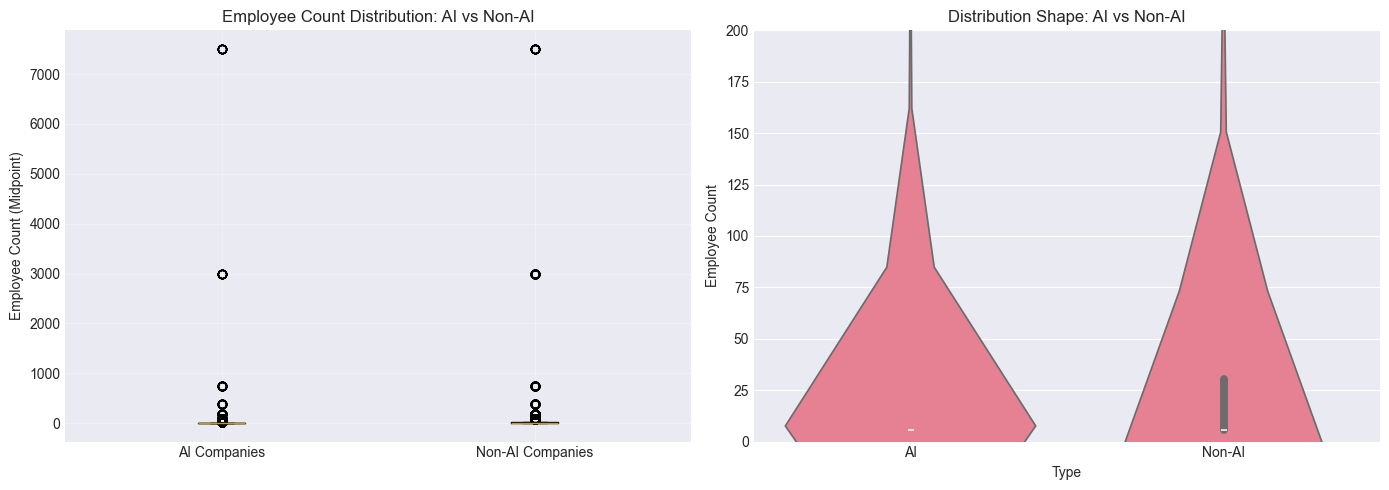


💡 INTERPRETATION:
✓ Statistically significant difference (p=0.0014)
  AI companies are smaller on average


In [35]:
# Cell 4: Part 2 - AI vs Non-AI Companies: t-test
"""
LEARNING CONCEPT: Independent Samples t-test

Purpose: Compare means between two independent groups
Assumptions: 
  - Independence of observations
  - Approximately normal distribution (or large sample)
  - Equal variances (Levene's test)

H0 (Null Hypothesis): AI and non-AI companies have equal mean employee counts
H1 (Alternative): They have different mean employee counts

📚 Quick Learn: https://www.youtube.com/watch?v=0Pd3dc1GcHc (t-test - 11 min)
"""

# Prepare groups
ai_companies = df[df['is_ai_company'] & df['employees_midpoint'].notna()]['employees_midpoint']
non_ai_companies = df[~df['is_ai_company'] & df['employees_midpoint'].notna()]['employees_midpoint']

print("=" * 60)
print("HYPOTHESIS TEST 1: AI vs NON-AI EMPLOYEE COUNTS")
print("=" * 60)

# Descriptive stats by group
print("\nDescriptive Statistics:")
print(f"AI Companies (n={len(ai_companies):,}):")
print(f"  Mean: {ai_companies.mean():.2f} employees")
print(f"  Median: {ai_companies.median():.2f} employees")
print(f"  Std: {ai_companies.std():.2f}")

print(f"\nNon-AI Companies (n={len(non_ai_companies):,}):")
print(f"  Mean: {non_ai_companies.mean():.2f} employees")
print(f"  Median: {non_ai_companies.median():.2f} employees")
print(f"  Std: {non_ai_companies.std():.2f}")

# Test for equal variances (Levene's test)
levene_stat, levene_p = stats.levene(ai_companies, non_ai_companies)
print(f"\nLevene's Test for Equal Variances:")
print(f"  Statistic: {levene_stat:.4f}")
print(f"  P-value: {levene_p:.4f}")
print(f"  Result: {'Unequal' if levene_p < 0.05 else 'Equal'} variances (p < 0.05)")

# Perform t-test
t_stat, t_p = stats.ttest_ind(ai_companies, non_ai_companies, equal_var=(levene_p >= 0.05))

print(f"\nIndependent t-test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {t_p:.4e}")
print(f"  Significance: {'YES' if t_p < 0.05 else 'NO'} at α=0.05")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot comparison
axes[0].boxplot([ai_companies, non_ai_companies], labels=['AI Companies', 'Non-AI Companies'])
axes[0].set_ylabel('Employee Count (Midpoint)')
axes[0].set_title('Employee Count Distribution: AI vs Non-AI')
axes[0].grid(True, alpha=0.3)

# Violin plot (shows distribution shape)
data_to_plot = pd.DataFrame({
    'Employee Count': pd.concat([ai_companies, non_ai_companies]),
    'Type': ['AI'] * len(ai_companies) + ['Non-AI'] * len(non_ai_companies)
})
sns.violinplot(data=data_to_plot, x='Type', y='Employee Count', ax=axes[1])
axes[1].set_title('Distribution Shape: AI vs Non-AI')
axes[1].set_ylim(0, 200)  # Focus on main distribution

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETATION:")
if t_p < 0.05:
    print(f"✓ Statistically significant difference (p={t_p:.4f})")
    print(f"  AI companies are {'smaller' if ai_companies.mean() < non_ai_companies.mean() else 'larger'} on average")
else:
    print(f"✗ No statistically significant difference (p={t_p:.4f})")
    print("  Cannot conclude that AI companies differ in size from non-AI companies")

In [36]:
# Cell 5: Part 3 - Non-Parametric Alternative: Mann-Whitney U Test
"""
LEARNING CONCEPT: Mann-Whitney U Test (Wilcoxon Rank-Sum)

Use when:
  - Data is NOT normally distributed (our case!)
  - Comparing medians instead of means
  - More robust to outliers

📚 Quick Learn: https://www.youtube.com/watch?v=BT1FKd1Qzjw (Mann-Whitney - 8 min)
"""

print("=" * 60)
print("HYPOTHESIS TEST 2: MANN-WHITNEY U TEST")
print("=" * 60)

# Perform Mann-Whitney U test
u_stat, u_p = stats.mannwhitneyu(ai_companies, non_ai_companies, alternative='two-sided')

print(f"\nMann-Whitney U Test:")
print(f"  U-statistic: {u_stat:,.0f}")
print(f"  P-value: {u_p:.4e}")
print(f"  Significance: {'YES' if u_p < 0.05 else 'NO'} at α=0.05")

print("\n📊 Comparison with t-test:")
print(f"  t-test p-value: {t_p:.4e}")
print(f"  Mann-Whitney p-value: {u_p:.4e}")
print(f"  {'Both tests agree!' if (t_p < 0.05) == (u_p < 0.05) else 'Tests disagree - use Mann-Whitney (data not normal)'}")

print("\n💡 KEY INSIGHT:")
print("Mann-Whitney is preferred here because:")
print("  - Employee counts are heavily right-skewed")
print("  - Compares medians (more representative of 'typical' company)")
print("  - Robust to outliers (giant companies don't skew results)")

HYPOTHESIS TEST 2: MANN-WHITNEY U TEST

Mann-Whitney U Test:
  U-statistic: 67,688,840
  P-value: 3.2671e-03
  Significance: YES at α=0.05

📊 Comparison with t-test:
  t-test p-value: 1.4044e-03
  Mann-Whitney p-value: 3.2671e-03
  Both tests agree!

💡 KEY INSIGHT:
Mann-Whitney is preferred here because:
  - Employee counts are heavily right-skewed
  - Compares medians (more representative of 'typical' company)
  - Robust to outliers (giant companies don't skew results)


In [37]:
# Cell 6: Part 4 - Effect Size (Cohen's d)
"""
LEARNING CONCEPT: Effect Size

Why it matters:
  - Statistical significance ≠ practical significance
  - p-value depends on sample size (large samples = easy significance)
  - Effect size tells us HOW MUCH difference there is

Cohen's d interpretation:
  - Small effect: d = 0.2
  - Medium effect: d = 0.5
  - Large effect: d = 0.8+

📚 Quick Learn: https://www.youtube.com/watch?v=HEGwBf5YomA (Effect Size - 9 min)
"""

def cohen_d(group1, group2):
    """Calculate Cohen's d for independent samples"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # Cohen's d
    d = (np.mean(group1) - np.mean(group2)) / pooled_std
    return d

# Calculate effect size
effect_size = cohen_d(ai_companies, non_ai_companies)

print("=" * 60)
print("EFFECT SIZE ANALYSIS")
print("=" * 60)

print(f"\nCohen's d: {effect_size:.4f}")

# Interpret
if abs(effect_size) < 0.2:
    interpretation = "Negligible/Very Small"
elif abs(effect_size) < 0.5:
    interpretation = "Small"
elif abs(effect_size) < 0.8:
    interpretation = "Medium"
else:
    interpretation = "Large"

print(f"Effect Size: {interpretation}")

print(f"\n💡 PRACTICAL INTERPRETATION:")
print(f"  Statistical significance (p={u_p:.4e}): {'YES' if u_p < 0.05 else 'NO'}")
print(f"  Practical significance (Cohen's d={effect_size:.3f}): {interpretation}")

if u_p < 0.05 and abs(effect_size) < 0.2:
    print("\n⚠️  WARNING: Statistically significant but small effect!")
    print("    This is common with large datasets - difference exists but may not matter in practice")
elif u_p >= 0.05 and abs(effect_size) >= 0.5:
    print("\n⚠️  Note: Medium/large effect but not statistically significant")
    print("    May need more data to detect this difference reliably")
else:
    print(f"\n✓ {'Meaningful' if abs(effect_size) >= 0.5 else 'Limited'} practical difference between groups")

EFFECT SIZE ANALYSIS

Cohen's d: -0.0405
Effect Size: Negligible/Very Small

💡 PRACTICAL INTERPRETATION:
  Statistical significance (p=3.2671e-03): YES
  Practical significance (Cohen's d=-0.041): Negligible/Very Small

⚠️  WARNING: Statistically significant but small effect!
    This is common with large datasets - difference exists but may not matter in practice


HYPOTHESIS TEST 3: CHI-SQUARE TEST

Contingency Table:
has_funding    False  True  Total
is_ai_company                    
False          12696  2643  15339
True            7703  2970  10673
Total          20399  5613  26012

Proportions:
has_funding    False  True 
is_ai_company              
False          82.77  17.23
True           72.17  27.83

Chi-Square Test Results:
  χ² statistic: 417.0021
  Degrees of freedom: 1
  P-value: 1.0964e-92
  Significance: YES at α=0.05

Expected Frequencies (for validity check):
          No Funding  Has Funding
Non-AI  12029.073543  3309.926457
AI       8369.926457  2303.073543

📋 Assumptions Check:
  All expected frequencies ≥ 5? True

Cramér's V (effect size): 0.1266
  Interpretation: Moderate association


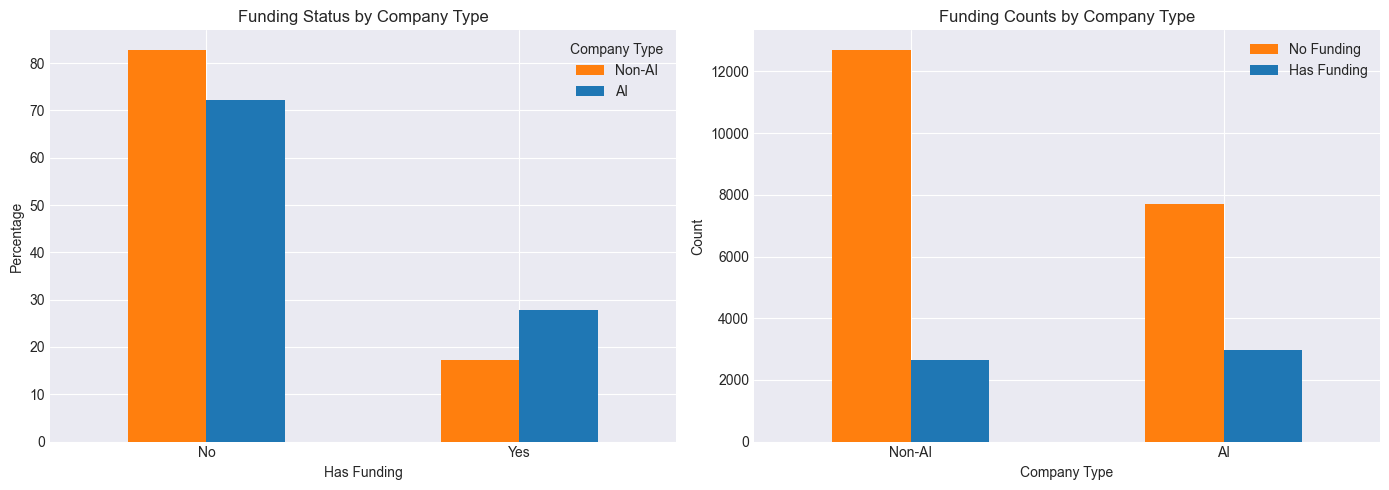


💡 INTERPRETATION:
✓ Significant association found (p=1.0964e-92)
  AI companies: 27.8% have funding
  Non-AI companies: 17.2% have funding
  Difference: 10.6 percentage points


In [38]:
# Cell 7: Part 5 - Chi-Square Test for Categorical Variables
"""
LEARNING CONCEPT: Chi-Square Test of Independence

Purpose: Test if two categorical variables are related
Example: Is "having funding" independent of "being an AI company"?

H0: Variables are independent (no relationship)
H1: Variables are dependent (relationship exists)

📚 Quick Learn: https://www.youtube.com/watch?v=ZjdBM7NO7bY (Chi-Square - 6 min)
"""

print("=" * 60)
print("HYPOTHESIS TEST 3: CHI-SQUARE TEST")
print("=" * 60)

# Create binary funding variable
if 'funding_total_numeric' in df.columns:
    df['has_funding'] = df['funding_total_numeric'].notna() & (df['funding_total_numeric'] > 0)
    
    # Create contingency table
    contingency_table = pd.crosstab(df['is_ai_company'], df['has_funding'], 
                                    margins=True, margins_name='Total')
    
    print("\nContingency Table:")
    print(contingency_table)
    
    # Calculate proportions
    print("\nProportions:")
    prop_table = pd.crosstab(df['is_ai_company'], df['has_funding'], normalize='index') * 100
    print(prop_table.round(2))
    
    # Chi-square test
    chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table.iloc[:-1, :-1])
    
    print(f"\nChi-Square Test Results:")
    print(f"  χ² statistic: {chi2:.4f}")
    print(f"  Degrees of freedom: {dof}")
    print(f"  P-value: {p_val:.4e}")
    print(f"  Significance: {'YES' if p_val < 0.05 else 'NO'} at α=0.05")
    
    # Expected frequencies
    print(f"\nExpected Frequencies (for validity check):")
    print(pd.DataFrame(expected, 
                      index=['Non-AI', 'AI'],
                      columns=['No Funding', 'Has Funding']))
    
    print("\n📋 Assumptions Check:")
    print(f"  All expected frequencies ≥ 5? {(expected >= 5).all()}")
    
    # Cramér's V (effect size for chi-square)
    n = contingency_table.iloc[:-1, :-1].sum().sum()
    cramers_v = np.sqrt(chi2 / n)
    print(f"\nCramér's V (effect size): {cramers_v:.4f}")
    print(f"  Interpretation: {'Weak' if cramers_v < 0.1 else 'Moderate' if cramers_v < 0.3 else 'Strong'} association")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Stacked bar chart
    prop_table.T.plot(kind='bar', stacked=False, ax=axes[0], color=['#ff7f0e', '#1f77b4'])
    axes[0].set_ylabel('Percentage')
    axes[0].set_title('Funding Status by Company Type')
    axes[0].set_xlabel('Has Funding')
    axes[0].set_xticklabels(['No', 'Yes'], rotation=0)
    axes[0].legend(['Non-AI', 'AI'], title='Company Type')
    
    # Grouped bar chart
    contingency_table.iloc[:-1, :-1].plot(kind='bar', ax=axes[1], color=['#ff7f0e', '#1f77b4'])
    axes[1].set_ylabel('Count')
    axes[1].set_title('Funding Counts by Company Type')
    axes[1].set_xlabel('Company Type')
    axes[1].set_xticklabels(['Non-AI', 'AI'], rotation=0)
    axes[1].legend(['No Funding', 'Has Funding'])
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 INTERPRETATION:")
    if p_val < 0.05:
        print(f"✓ Significant association found (p={p_val:.4e})")
        ai_funding_rate = prop_table.loc[True, True]
        non_ai_funding_rate = prop_table.loc[False, True]
        print(f"  AI companies: {ai_funding_rate:.1f}% have funding")
        print(f"  Non-AI companies: {non_ai_funding_rate:.1f}% have funding")
        print(f"  Difference: {abs(ai_funding_rate - non_ai_funding_rate):.1f} percentage points")
    else:
        print(f"✗ No significant association (p={p_val:.4f})")
        print("  Funding status appears independent of AI classification")
else:
    print("⚠️  Funding data not available - skipping this analysis")
    print("   Run crunchbase_financial_data.py to fetch funding information")

CORRELATION ANALYSIS

Pearson Correlation Matrix (linear relationships):
                       employees_midpoint  category_count  \
employees_midpoint                  1.000           0.005   
category_count                      0.005           1.000   
funding_total_numeric               0.282          -0.016   
num_funding_rounds                  0.000           0.117   

                       funding_total_numeric  num_funding_rounds  
employees_midpoint                     0.282               0.000  
category_count                        -0.016               0.117  
funding_total_numeric                  1.000               0.062  
num_funding_rounds                     0.062               1.000  

Spearman Correlation Matrix (monotonic relationships):
                       employees_midpoint  category_count  \
employees_midpoint                  1.000           0.051   
category_count                      0.051           1.000   
funding_total_numeric               0.354      

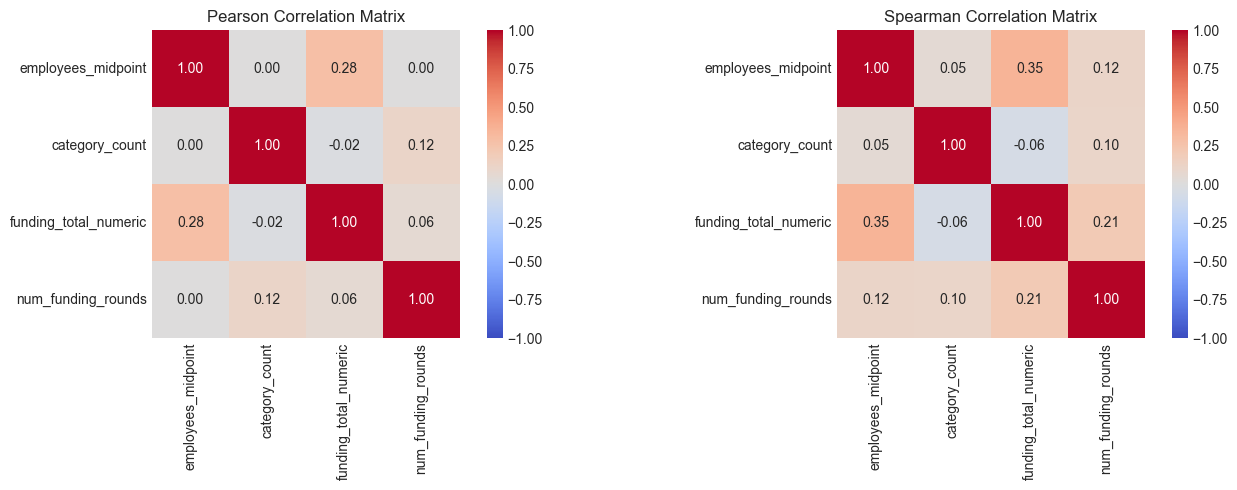


POINT-BISERIAL CORRELATION (Binary vs Continuous)

AI Company vs Employee Count:
  r = -0.0176
  p-value = 4.6461e-03
  Interpretation: Significant negative correlation

AI Company vs Has Funding:
  r = 0.1267
  p-value = 1.4959e-93
  Interpretation: Significant positive correlation

💡 CORRELATION INTERPRETATION GUIDE:
  |r| < 0.1  : Negligible correlation
  |r| < 0.3  : Weak correlation
  |r| < 0.5  : Moderate correlation
  |r| < 0.7  : Strong correlation
  |r| ≥ 0.7  : Very strong correlation

  ⚠️  Remember: Correlation ≠ Causation!


In [39]:
# Cell 8: Part 6 - Correlation Analysis
"""
LEARNING CONCEPT: Correlation Analysis

Types:
  - Pearson: Linear relationships, continuous variables
  - Spearman: Monotonic relationships, handles ordinal data
  - Point-biserial: Continuous vs binary variable

Correlation coefficient (r):
  - r = 1: Perfect positive correlation
  - r = 0: No correlation
  - r = -1: Perfect negative correlation
  
📚 Quick Learn: https://www.youtube.com/watch?v=xZ_z8KWkhXE (Correlation - 6 min)
"""

print("=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

# Select numeric columns for correlation
numeric_cols = ['employees_midpoint', 'category_count']
if 'funding_total_numeric' in df.columns:
    numeric_cols.append('funding_total_numeric')
if 'num_funding_rounds' in df.columns:
    numeric_cols.append('num_funding_rounds')

# Create correlation matrix
corr_data = df[numeric_cols].copy()

# Calculate both Pearson and Spearman
pearson_corr = corr_data.corr(method='pearson')
spearman_corr = corr_data.corr(method='spearman')

print("\nPearson Correlation Matrix (linear relationships):")
print(pearson_corr.round(3))

print("\nSpearman Correlation Matrix (monotonic relationships):")
print(spearman_corr.round(3))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pearson heatmap
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, ax=axes[0], fmt='.2f')
axes[0].set_title('Pearson Correlation Matrix')

# Spearman heatmap
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[1], fmt='.2f')
axes[1].set_title('Spearman Correlation Matrix')

plt.tight_layout()
plt.show()

# Point-biserial correlation (continuous vs binary)
print("\n" + "=" * 60)
print("POINT-BISERIAL CORRELATION (Binary vs Continuous)")
print("=" * 60)

# AI company (binary) vs employee count (continuous)
rpb_emp, p_emp = stats.pointbiserialr(df['is_ai_company'], df['employees_midpoint'].fillna(0))
print(f"\nAI Company vs Employee Count:")
print(f"  r = {rpb_emp:.4f}")
print(f"  p-value = {p_emp:.4e}")
print(f"  Interpretation: {'Significant' if p_emp < 0.05 else 'Not significant'} {'positive' if rpb_emp > 0 else 'negative'} correlation")

if 'has_funding' in df.columns:
    rpb_fund, p_fund = stats.pointbiserialr(df['is_ai_company'], df['has_funding'])
    print(f"\nAI Company vs Has Funding:")
    print(f"  r = {rpb_fund:.4f}")
    print(f"  p-value = {p_fund:.4e}")
    print(f"  Interpretation: {'Significant' if p_fund < 0.05 else 'Not significant'} {'positive' if rpb_fund > 0 else 'negative'} correlation")

print("\n💡 CORRELATION INTERPRETATION GUIDE:")
print("  |r| < 0.1  : Negligible correlation")
print("  |r| < 0.3  : Weak correlation")
print("  |r| < 0.5  : Moderate correlation")
print("  |r| < 0.7  : Strong correlation")
print("  |r| ≥ 0.7  : Very strong correlation")
print("\n  ⚠️  Remember: Correlation ≠ Causation!")

BOOTSTRAP CONFIDENCE INTERVALS

95% Bootstrap CI for AI Companies Mean Employee Count:
  Point estimate: 25.31
  95% CI: [20.95, 30.27]
  Interpretation: We are 95% confident the true mean is between 20.95 and 30.27

95% Bootstrap CI for Non-AI Companies Mean Employee Count:
  Point estimate: 36.31
  95% CI: [31.59, 41.52]

Do confidence intervals overlap? False
  → Strong evidence that means differ


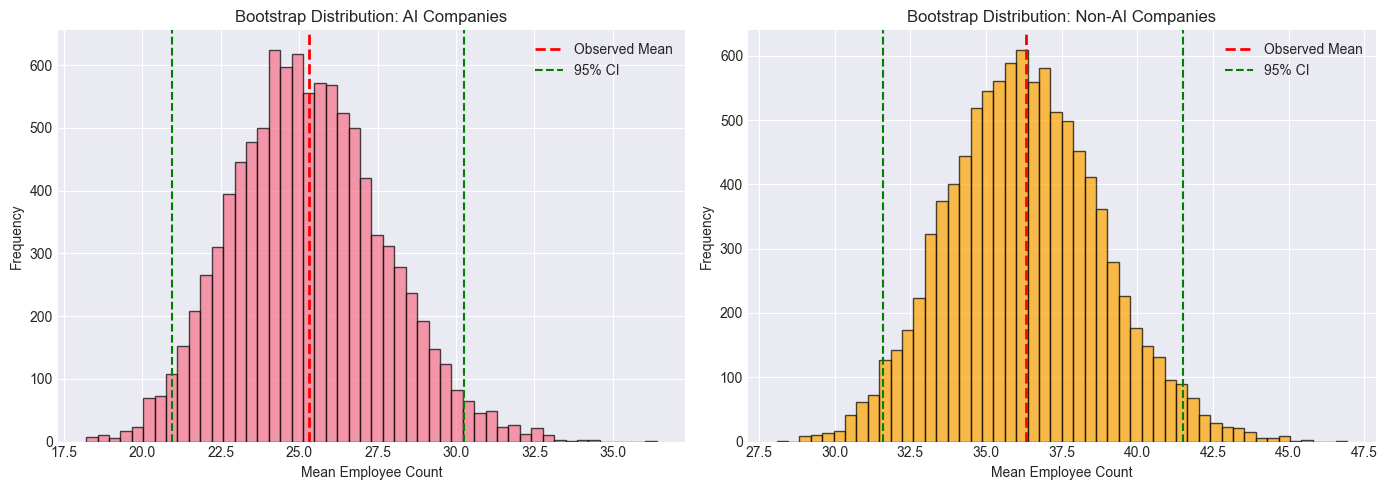


💡 WHY BOOTSTRAP?
  ✓ Works with any statistic (mean, median, custom functions)
  ✓ No assumption about underlying distribution
  ✓ Provides empirical confidence intervals
  ✓ Especially useful for small samples or complex statistics


In [40]:
# Cell 9: Part 7 - Bootstrap Confidence Intervals
"""
LEARNING CONCEPT: Bootstrap Method

Purpose: Estimate confidence intervals without assuming distribution
Process:
  1. Resample data with replacement
  2. Calculate statistic on resampled data
  3. Repeat many times
  4. Use percentiles as confidence interval

📚 Quick Learn: https://www.youtube.com/watch?v=Xz0x-8-cgaQ (Bootstrapping - 9 min)
"""

print("=" * 60)
print("BOOTSTRAP CONFIDENCE INTERVALS")
print("=" * 60)

def bootstrap_ci(data, stat_func=np.mean, n_bootstrap=10000, confidence=0.95):
    """Calculate bootstrap confidence interval"""
    bootstrap_stats = []
    n = len(data)
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        sample = np.random.choice(data, size=n, replace=True)
        bootstrap_stats.append(stat_func(sample))
    
    # Calculate percentiles
    alpha = (1 - confidence) / 2
    lower = np.percentile(bootstrap_stats, alpha * 100)
    upper = np.percentile(bootstrap_stats, (1 - alpha) * 100)
    
    return lower, upper, bootstrap_stats

# Bootstrap for AI companies mean employee count
ai_emp_clean = ai_companies.dropna().values
lower_ai, upper_ai, boot_stats_ai = bootstrap_ci(ai_emp_clean, np.mean)

print(f"\n95% Bootstrap CI for AI Companies Mean Employee Count:")
print(f"  Point estimate: {ai_emp_clean.mean():.2f}")
print(f"  95% CI: [{lower_ai:.2f}, {upper_ai:.2f}]")
print(f"  Interpretation: We are 95% confident the true mean is between {lower_ai:.2f} and {upper_ai:.2f}")

# Bootstrap for Non-AI companies
non_ai_emp_clean = non_ai_companies.dropna().values
lower_non_ai, upper_non_ai, boot_stats_non_ai = bootstrap_ci(non_ai_emp_clean, np.mean)

print(f"\n95% Bootstrap CI for Non-AI Companies Mean Employee Count:")
print(f"  Point estimate: {non_ai_emp_clean.mean():.2f}")
print(f"  95% CI: [{lower_non_ai:.2f}, {upper_non_ai:.2f}]")

# Check if CIs overlap
overlap = not (upper_ai < lower_non_ai or upper_non_ai < lower_ai)
print(f"\nDo confidence intervals overlap? {overlap}")
if not overlap:
    print("  → Strong evidence that means differ")
else:
    print("  → Confidence intervals overlap; difference may not be meaningful")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bootstrap distribution for AI companies
axes[0].hist(boot_stats_ai, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(ai_emp_clean.mean(), color='red', linestyle='--', linewidth=2, label='Observed Mean')
axes[0].axvline(lower_ai, color='green', linestyle='--', label='95% CI')
axes[0].axvline(upper_ai, color='green', linestyle='--')
axes[0].set_xlabel('Mean Employee Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Bootstrap Distribution: AI Companies')
axes[0].legend()

# Bootstrap distribution for Non-AI companies
axes[1].hist(boot_stats_non_ai, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1].axvline(non_ai_emp_clean.mean(), color='red', linestyle='--', linewidth=2, label='Observed Mean')
axes[1].axvline(lower_non_ai, color='green', linestyle='--', label='95% CI')
axes[1].axvline(upper_non_ai, color='green', linestyle='--')
axes[1].set_xlabel('Mean Employee Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Bootstrap Distribution: Non-AI Companies')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n💡 WHY BOOTSTRAP?")
print("  ✓ Works with any statistic (mean, median, custom functions)")
print("  ✓ No assumption about underlying distribution")
print("  ✓ Provides empirical confidence intervals")
print("  ✓ Especially useful for small samples or complex statistics")

In [41]:
# Cell 10: Part 8 - Multiple Testing Correction
"""
LEARNING CONCEPT: Multiple Testing Problem

Issue: When doing many tests, some will be significant by chance
Solution: Adjust p-values to control family-wise error rate

Bonferroni Correction: α_new = α / number_of_tests
  - Conservative but simple
  - Use when tests are independent

📚 Learn More: https://www.statisticshowto.com/bonferroni-correction/
"""

print("=" * 60)
print("MULTIPLE TESTING CORRECTION")
print("=" * 60)

# Let's test multiple sectors against each other
sectors_to_test = ['Software', 'SaaS', 'Health Care', 'FinTech', 'Blockchain']

results = []
for sector in sectors_to_test:
    mask = df['categories'].str.contains(sector, na=False, case=False)
    sector_data = df[mask & df['employees_midpoint'].notna()]['employees_midpoint']
    non_sector_data = df[~mask & df['employees_midpoint'].notna()]['employees_midpoint']
    
    if len(sector_data) > 0:
        # Mann-Whitney U test
        u_stat, p_val = stats.mannwhitneyu(sector_data, non_sector_data, alternative='two-sided')
        results.append({
            'Sector': sector,
            'n': len(sector_data),
            'Mean': sector_data.mean(),
            'p-value': p_val,
            'Significant (α=0.05)': p_val < 0.05
        })

results_df = pd.DataFrame(results)

# Apply Bonferroni correction
n_tests = len(results_df)
bonferroni_alpha = 0.05 / n_tests
results_df['Bonferroni Corrected'] = results_df['p-value'] < bonferroni_alpha

print(f"\nNumber of tests: {n_tests}")
print(f"Original α: 0.05")
print(f"Bonferroni-corrected α: {bonferroni_alpha:.4f}")

print("\nResults:")
print(results_df.to_string(index=False))

print(f"\n📊 Impact of correction:")
print(f"  Significant before correction: {results_df['Significant (α=0.05)'].sum()}/{n_tests}")
print(f"  Significant after correction: {results_df['Bonferroni Corrected'].sum()}/{n_tests}")

print("\n💡 KEY LESSON:")
print("  Multiple testing increases false positive risk")
print("  Without correction: 5% chance of Type I error per test")
print(f"  With {n_tests} tests: ~{(1 - (0.95**n_tests))*100:.1f}% chance of at least one false positive")
print("  Bonferroni correction controls this risk")

MULTIPLE TESTING CORRECTION

Number of tests: 5
Original α: 0.05
Bonferroni-corrected α: 0.0100

Results:
     Sector    n      Mean      p-value  Significant (α=0.05)  Bonferroni Corrected
   Software 5376 19.436012 1.444986e-14                  True                  True
       SaaS 1824 18.485197 1.042197e-08                  True                  True
Health Care 1216 33.468750 3.456551e-02                  True                 False
    FinTech  772 22.255181 5.900357e-02                 False                 False
 Blockchain  565 20.234513 4.027309e-14                  True                  True

📊 Impact of correction:
  Significant before correction: 4/5
  Significant after correction: 3/5

💡 KEY LESSON:
  Multiple testing increases false positive risk
  Without correction: 5% chance of Type I error per test
  With 5 tests: ~22.6% chance of at least one false positive
  Bonferroni correction controls this risk
